<font color=darkred>

# Soc220: Computational Text Analysis
## Lab4 (Week 5): Text preprocessing and cleaning

<br>

<img src="mickey.jpg" alt="Drawing" style="width: 900px;"/>

***
    2/21/18

***

## Today:

Like Mickey as sorcerer's apprentice, we're going to automate cleaning texts, and while necessary, we can also end up with useless stuff everywhere.

Denny and Spirling (Forthcoming): preprocessing should (1) reduce computational complexity, (2) reduce noise, and (3) allow for better human interptability. 

As a consequence of 7 different preprocessing decisions, they suggest $2^7 = 128$ possible configurations of a given corpus. Think: probability space over the various models (plus some error), but also space over possible configurations.

So, what to do? 

Follow the steps they suggest and check in each time to see how a simple word frequency count changes. Along the way: Pandas and simple visualizations.

Then, following Grimmer and Stewart (2013), we're going to bag-o-words as the ''standard'' recipe.

Lastly, we'll discuss using a tokenizer to do exploration.

**
<em>
Denny and Spirling:**

0.) Basic cleaning (removing artifacts of code/scrape, encoding?, maybe spell check?) <br>
1.) Punctuation removal <br>
2.) Numbers removal (or transformation into text) <br>
3.) Lowecase <br>
4.) Stemming (/lemmatizing) words <br>
5.) Stop-words removal <br>
6.) N-gram size <br>
7.) Infrequent term removal

In [1]:
#!pip install -U nltk

In [2]:
#!pip install -U spacy

In [3]:
#!python -m spacy download en

In [4]:
#!pip install -U gensim

In [5]:
#nltk.download()

<font color=darkred>

### Great code for getting around Harvard login. (Thanks Ariella!)


Great for getting databases:

http://e-research.lib.harvard.edu/V?func=find-db-1

### To do list:

1. ML to fix OCR.
2. Bulk extracting PDFs for OCRing.

<font color=darkgreen>


### 0. Loading and wrangling some data from a pickle object

Data: Verbatim accounts of (UK) House of Commons debates for the period 1660-1739

Why you should care:

1. 1642, English Civil War starts -- republican government experiment.
1. 1649, King Charles I decapitated.
1. 1660, Restoration: Charles' brother takes over as Charles II.
2. 1660, the corpose of Oliver Cromwell is put on trial (found guilty), and he is re-hung and depicated.
3. 1672, King declares bankruptcy.
5. 1688, another coup, this time James I is dethroned.
6. 1689, constitutional monarchy established.
7. 1694, Bank of England financies the state.
8. 1697, East India Company is re-started
7. 1707, unity of Scotland and England creats Great Britain
8. 1714, beginning of 'Whig Supremacy.'
9. 1722, South Sea Bubble.
10. 1730s, Coffee-houses of English financial capitalism in Exchange Alley, the site of where modern London Stock Exchanges.

## AKA YOUR DATA GOES HERE

In [1]:
import pickle

#n.b. 'read binary'
session_texts = pickle.load(open("session_singular_texts.p", "rb" ))
session_titles = pickle.load(open("sessions_titles.p", "rb" ))

In [2]:
len(session_texts)

198

In [3]:
len(session_titles)

198

In [4]:
session_titles[20:35]

['The second parliament of Charles II: Seventeenth session - begins 23/5/1678',
 'The second parliament of Charles II: Eighteenth session - begins 21/10/1678',
 'The third Parliament of Charles II: First session - begins 6/3/1679',
 'The fourth Parliament of Charles II: First session (1 of 5) - begins 17/10/1679',
 'The fourth Parliament of Charles II: First session (2 of 5)- begins 4/11/1680',
 'The fourth Parliament of Charles II: First session (3 of 5) - begins 12/11/1680',
 'The fourth Parliament of Charles II: First session (4 of 5) - begins 21/10/1680',
 'The fourth Parliament of Charles II: First session (5 of 5) - begins 23/12/1680',
 'The Oxford Parliament: - begins 21/3/1681',
 "King James' Parliament: The first convention - begins 19/5/1685",
 "King James' Parliament: The second convention - begins 22/1/1689",
 "King James' Parliament: The succession of William and Mary - begins 13/2/1689",
 'The Convention Parliament (William): The convention becomes a Parliament - begins 2

In [5]:
example_title = session_titles[25]
session_titles[25]

'The fourth Parliament of Charles II: First session (3 of 5) - begins 12/11/1680'

In [6]:
import re

In [7]:
re.findall(r"/[\d]+", example_title)

['/11', '/1680']

In [8]:
re.findall(r"/[\d]+", example_title)[0].strip('/')

'11'

In [9]:
re.findall(r"/[\d]+", example_title)[1].strip('/')

'1680'

### Getting the names of monarchs

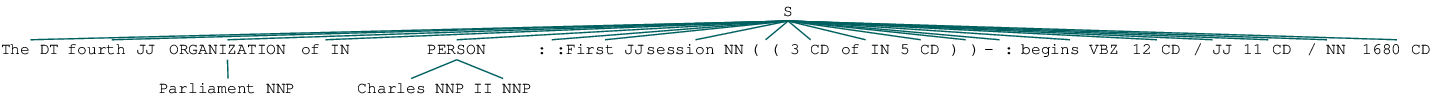

In [11]:
import nltk
#from nltk import word_tokenize, pos_tag, ne_chunk

tokens = nltk.wordpunct_tokenize(example_title)
nltk.ne_chunk(nltk.pos_tag(tokens))

In [12]:
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('fourth', 'JJ'),
 ('Parliament', 'NNP'),
 ('of', 'IN'),
 ('Charles', 'NNP'),
 ('II', 'NNP'),
 (':', ':'),
 ('First', 'JJ'),
 ('session', 'NN'),
 ('(', '('),
 ('3', 'CD'),
 ('of', 'IN'),
 ('5', 'CD'),
 (')', ')'),
 ('-', ':'),
 ('begins', 'VBZ'),
 ('12', 'CD'),
 ('/', 'JJ'),
 ('11', 'CD'),
 ('/', 'NN'),
 ('1680', 'CD')]

In [13]:
import spacy
spacy = spacy.load('en',tagger=False,parser=False,matcher=False)

spacy_example_title = spacy(example_title)
for token in spacy_example_title:
    print(token.text,'--->',token.pos_)

The ---> DET
fourth ---> ADJ
Parliament ---> PROPN
of ---> ADP
Charles ---> PROPN
II ---> PROPN
: ---> PUNCT
First ---> ADJ
session ---> NOUN
( ---> PUNCT
3 ---> NUM
of ---> ADP
5 ---> NUM
) ---> PUNCT
- ---> PUNCT
begins ---> VERB
12/11/1680 ---> NUM


In [14]:
for entity in spacy_example_title.ents:
    print(entity.text, entity.label_)

fourth ORDINAL
Parliament of Charles II ORG
First ORDINAL
3 CARDINAL
5 CARDINAL
12/11/1680 DATE


In [15]:
[token.text for token in spacy(example_title) if token.pos_ == 'PROPN']

['Parliament', 'Charles', 'II']

In [16]:
[entity.text for entity in spacy(example_title).ents if entity.label_ == 'PERSON']

[]

In [17]:
#suffix
re.findall(r"(?:[A-Z][A-Z'\-_]+)",example_title)

['II']

In [18]:
monarchs_list = []
dates_list = []
proceedings_text_list = []

for title, text in zip(session_titles, session_texts):
    
    try:
        month = re.findall(r"/[\d]+", title)[0].strip('/')
        #print(month)
        
        year = re.findall(r"/[\d]+", title)[1].strip('/')
        #print(year)
        
        date = year+'_'+month
        print(date)
        
        monarch = [token.text for token in spacy(title) if token.tag_ == 'NNP']
        print('\t',monarch)
        
        print('\t\t',str(text[1000:1050]))
        
        monarchs_list.append(monarch)
        dates_list.append(date)
        proceedings_text_list.append(str(text))
        
        
    except IndexError:
        print('passed')

passed
1660_4
	 ['Convention', 'Parliament']
		 ess, and Security of the Kingdom.", "'We do assure
1660_11
	 ['Convention', 'Parliament']
		 easons, he had determined to\ndissolve them in the
1661_5
	 ['Charles', 'II']
		 the Year, and all that has been done since we part
1661_11
	 ['Charles', 'II']
		 hat extraordinary:\nIt is to say something to you 
1663_2
	 ['Charles', 'II']
		 shall have\nexamin'd well the grounds, I doubt not
1664_3
	 ['Charles', 'II']
		 ept without a Parliament. I pray watch these Whisp
1664_11
	 ['Charles', 'II']
		  hath been deferred thus\nlong: You have had leisu
1665_10
	 ['Charles', 'II', 'Oxford']
		 'The truth is, as I enter'd upon this War by your\
1666_9
	 ['Charles', 'II']
		 n; and I can tell you truly, I desire to put you t
1667_7
	 ['Charles', 'II']
		  of this Month; and that the\nHouse should be adjo
1667_10
	 ['Charles', 'II']
		 you.'", "Hereupon the new Lord-Keeper Bridgeman ma
1669_10
	 ['Charles', 'II']
		  to the Navy, and that extraordina

	 ['First', 'Parliament', 'George', 'II']
		 .", 'My Lords and Gentlemen,', '"It is a great Sat
1729_1
	 ['First', 'Parliament', 'George', 'II']
		 ell under\nConsideration, in settling and reconcil
1730_1
	 ['First', 'Parliament', 'George', 'II']
		 the Foundation, and is\nagreeable to the Purport a
1731_1
	 ['First', 'Parliament', 'George', 'II']
		 s; and no Endeavours have been wanting, conformabl
1732_1
	 ['First', 'Parliament', 'George', 'II']
		 of concluding\nthe Quadruple Alliance, the several
1732_1
	 ['First', 'Parliament', 'George', 'II']
		 on this Occasion, he moved, 'That the Bill\nmight 
1732_2
	 ['First', 'Parliament', 'George', 'II']
		 enever he\nis necessarily obliged to desire Assist
1732_2
	 ['First', 'Parliament', 'George', 'II']
		 also the 17th, 18th, and 23d, during which\nTime a
1733_1
	 ['First', 'Parliament', 'George', 'II']
		 u will, with the same Chearfulness as I have alway
1733_2
	 ['First', 'Parliament', 'George', 'II']
		  directly into Ireland from 

In [19]:
len(monarchs_list)

139

In [20]:
len(dates_list)

139

In [21]:
len(proceedings_text_list)

139

## Data structure choices

In [22]:
# 'Charles II' * [:28] 
# 'James' * 3 [28:31]
# 'Convention' [:3]; [32:34]
# 'William and Mary' [34:46]
# 'Anne' [49:73]
# 'George I' [74:88]
# 'George II' [88:109]

monarchs = ['charles2','james','convention','william_mary','anne','george1','george2']
proceedings = [
    " ".join(proceedings_text_list[:28]),
    " ".join(proceedings_text_list[28:31]),
    " ".join(proceedings_text_list[:3]).join(proceedings_text_list[32:34]),
    " ".join(proceedings_text_list[34:46]),
    " ".join(proceedings_text_list[49:73]),
    " ".join(proceedings_text_list[74:88]),
    " ".join(proceedings_text_list[88:109])
]

### By Monarch

In [23]:
import pandas as pd

df_monarch = pd.DataFrame({
    'monarch':monarchs,
    'proceedings':proceedings
})
df_monarch

,monarch,proceedings
0,charles2,"['Pages 2-25', 'The History and Proceedings of..."
1,james,"['Pages 164-199', 'The History and Proceedings..."
2,convention,"['Pages 309-355', 'The History and Proceedings..."
3,william_mary,"['Pages 373-384', 'The History and Proceedings..."
4,anne,"['Pages 203-211', 'The History and Proceedings..."
5,george1,"['Pages 47-68', 'The History and Proceedings o..."
6,george2,"['Pages 15-31', 'The History and Proceedings o..."


### By date

In [24]:
df_date = pd.DataFrame({
    'date':dates_list,
    'proceedings':proceedings_text_list
})
df_date.head()

,date,proceedings
0,1660_4,"['Pages 2-25', 'The History and Proceedings of..."
1,1660_11,"['Pages 25-31', 'The History and Proceedings o..."
2,1661_5,"['Pages 31-46', 'The History and Proceedings o..."
3,1661_11,"['Pages 46-60', 'The History and Proceedings o..."
4,1663_2,"['Pages 60-72', 'The History and Proceedings o..."


<font color=darkred>

### Cleaning with a toy bit of text

In [80]:
#select just a bit of text to see what happens.
toy_text = proceedings_text_list[5][1000:1600]

In [81]:
toy_text

'ept without a Parliament. I pray watch these Whisperers all you can, as\\nMen who use their utmost endeavours to sow Jealousies\\nbetween You and Me; and I do promise you they shall\\nnot prevail with me; and I do promise myself, they shall\\nnot prevail with you: And the truth is, we are both concern\'d they shou\'d not; and we shall then, with God\'s\\nBlessing, prevent all the mischief they intend.", "\'You may judge by the late Treason in the North, for\\nwhich so many Men have been executed, how active the\\nSpirits of many of our old Enemies still are, notwithstanding all our Mercy. I do assure you'

<font color=darkgreen>

### 0. Basic cleaning: spell check(optional), removing artifacts from scrape, encoding characters.

In [82]:
toy_text.replace('\\n', ' ').replace('\\r', '').replace('\\t', '').replace("\\","").replace("-",'')

'ept without a Parliament. I pray watch these Whisperers all you can, as Men who use their utmost endeavours to sow Jealousies between You and Me; and I do promise you they shall not prevail with me; and I do promise myself, they shall not prevail with you: And the truth is, we are both concern\'d they shou\'d not; and we shall then, with God\'s Blessing, prevent all the mischief they intend.", "\'You may judge by the late Treason in the North, for which so many Men have been executed, how active the Spirits of many of our old Enemies still are, notwithstanding all our Mercy. I do assure you'

In [83]:
#nltk.clean_html(unescape(test_string.decode('utf8')))

In [84]:
def step0(text):
    corrected_text = toy_text.replace('\\n', ' ').replace('\r', '').replace('\t', '').replace("\\","").replace("-",'')
    #corrected_text = corrected_text.replace('The History and Proceedings of the House of Commons: Volume 1, \\
    #1660-1680. Originally published by Chandler, London, 1742.', '')
    
    #DONT COPY THIS PART OF TEXT
    #corrected_text = corrected_text[220:] #removes junk text from start of each page
    #corrected_text = corrected_text[:-50] #removes junk at very end of each proceeding
    return corrected_text

In [85]:
step0(toy_text)

'ept without a Parliament. I pray watch these Whisperers all you can, as Men who use their utmost endeavours to sow Jealousies between You and Me; and I do promise you they shall not prevail with me; and I do promise myself, they shall not prevail with you: And the truth is, we are both concern\'d they shou\'d not; and we shall then, with God\'s Blessing, prevent all the mischief they intend.", "\'You may judge by the late Treason in the North, for which so many Men have been executed, how active the Spirits of many of our old Enemies still are, notwithstanding all our Mercy. I do assure you'

In [86]:
toy_text = step0(toy_text)

In [87]:
toy_text

'ept without a Parliament. I pray watch these Whisperers all you can, as Men who use their utmost endeavours to sow Jealousies between You and Me; and I do promise you they shall not prevail with me; and I do promise myself, they shall not prevail with you: And the truth is, we are both concern\'d they shou\'d not; and we shall then, with God\'s Blessing, prevent all the mischief they intend.", "\'You may judge by the late Treason in the North, for which so many Men have been executed, how active the Spirits of many of our old Enemies still are, notwithstanding all our Mercy. I do assure you'

<font color=darkgreen>

### 1. Punctuation removal

#### punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

In [88]:
re.sub('[^A-Za-z0-9]+', ' ', str(toy_text))

'ept without a Parliament I pray watch these Whisperers all you can as Men who use their utmost endeavours to sow Jealousies between You and Me and I do promise you they shall not prevail with me and I do promise myself they shall not prevail with you And the truth is we are both concern d they shou d not and we shall then with God s Blessing prevent all the mischief they intend You may judge by the late Treason in the North for which so many Men have been executed how active the Spirits of many of our old Enemies still are notwithstanding all our Mercy I do assure you'

In [89]:
def step1(text):
    corrected_text = re.sub('[^A-Za-z0-9]+', ' ', str(text))
    corrected_text = corrected_text.split(' ') #split on white space into a list
    return corrected_text

In [90]:
toy_text = step1(toy_text)

In [91]:
toy_text

['ept',
 'without',
 'a',
 'Parliament',
 'I',
 'pray',
 'watch',
 'these',
 'Whisperers',
 'all',
 'you',
 'can',
 'as',
 'Men',
 'who',
 'use',
 'their',
 'utmost',
 'endeavours',
 'to',
 'sow',
 'Jealousies',
 'between',
 'You',
 'and',
 'Me',
 'and',
 'I',
 'do',
 'promise',
 'you',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'me',
 'and',
 'I',
 'do',
 'promise',
 'myself',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'you',
 'And',
 'the',
 'truth',
 'is',
 'we',
 'are',
 'both',
 'concern',
 'd',
 'they',
 'shou',
 'd',
 'not',
 'and',
 'we',
 'shall',
 'then',
 'with',
 'God',
 's',
 'Blessing',
 'prevent',
 'all',
 'the',
 'mischief',
 'they',
 'intend',
 'You',
 'may',
 'judge',
 'by',
 'the',
 'late',
 'Treason',
 'in',
 'the',
 'North',
 'for',
 'which',
 'so',
 'many',
 'Men',
 'have',
 'been',
 'executed',
 'how',
 'active',
 'the',
 'Spirits',
 'of',
 'many',
 'of',
 'our',
 'old',
 'Enemies',
 'still',
 'are',
 'notwithstanding',
 'all',
 'our',
 'Mercy',
 'I',

<font color=darkgreen>

### 2. Numbers removal

In [92]:
#We are now in list land so each command has to be done to a list of words
[word for word in toy_text if word.isalpha()]

['ept',
 'without',
 'a',
 'Parliament',
 'I',
 'pray',
 'watch',
 'these',
 'Whisperers',
 'all',
 'you',
 'can',
 'as',
 'Men',
 'who',
 'use',
 'their',
 'utmost',
 'endeavours',
 'to',
 'sow',
 'Jealousies',
 'between',
 'You',
 'and',
 'Me',
 'and',
 'I',
 'do',
 'promise',
 'you',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'me',
 'and',
 'I',
 'do',
 'promise',
 'myself',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'you',
 'And',
 'the',
 'truth',
 'is',
 'we',
 'are',
 'both',
 'concern',
 'd',
 'they',
 'shou',
 'd',
 'not',
 'and',
 'we',
 'shall',
 'then',
 'with',
 'God',
 's',
 'Blessing',
 'prevent',
 'all',
 'the',
 'mischief',
 'they',
 'intend',
 'You',
 'may',
 'judge',
 'by',
 'the',
 'late',
 'Treason',
 'in',
 'the',
 'North',
 'for',
 'which',
 'so',
 'many',
 'Men',
 'have',
 'been',
 'executed',
 'how',
 'active',
 'the',
 'Spirits',
 'of',
 'many',
 'of',
 'our',
 'old',
 'Enemies',
 'still',
 'are',
 'notwithstanding',
 'all',
 'our',
 'Mercy',
 'I',

In [93]:
def step2(text):
    corrected_text = [word for word in text if word.isalpha()]
    return corrected_text

In [94]:
toy_text = step2(toy_text)

In [95]:
toy_text

['ept',
 'without',
 'a',
 'Parliament',
 'I',
 'pray',
 'watch',
 'these',
 'Whisperers',
 'all',
 'you',
 'can',
 'as',
 'Men',
 'who',
 'use',
 'their',
 'utmost',
 'endeavours',
 'to',
 'sow',
 'Jealousies',
 'between',
 'You',
 'and',
 'Me',
 'and',
 'I',
 'do',
 'promise',
 'you',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'me',
 'and',
 'I',
 'do',
 'promise',
 'myself',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'you',
 'And',
 'the',
 'truth',
 'is',
 'we',
 'are',
 'both',
 'concern',
 'd',
 'they',
 'shou',
 'd',
 'not',
 'and',
 'we',
 'shall',
 'then',
 'with',
 'God',
 's',
 'Blessing',
 'prevent',
 'all',
 'the',
 'mischief',
 'they',
 'intend',
 'You',
 'may',
 'judge',
 'by',
 'the',
 'late',
 'Treason',
 'in',
 'the',
 'North',
 'for',
 'which',
 'so',
 'many',
 'Men',
 'have',
 'been',
 'executed',
 'how',
 'active',
 'the',
 'Spirits',
 'of',
 'many',
 'of',
 'our',
 'old',
 'Enemies',
 'still',
 'are',
 'notwithstanding',
 'all',
 'our',
 'Mercy',
 'I',

<font color=darkgreen>

### 3. Lowercase

In [96]:
def step3(text):
    corrected_text = [word.lower() for word in text]
    return corrected_text

In [97]:
toy_text = step3(toy_text)

In [98]:
toy_text

['ept',
 'without',
 'a',
 'parliament',
 'i',
 'pray',
 'watch',
 'these',
 'whisperers',
 'all',
 'you',
 'can',
 'as',
 'men',
 'who',
 'use',
 'their',
 'utmost',
 'endeavours',
 'to',
 'sow',
 'jealousies',
 'between',
 'you',
 'and',
 'me',
 'and',
 'i',
 'do',
 'promise',
 'you',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'me',
 'and',
 'i',
 'do',
 'promise',
 'myself',
 'they',
 'shall',
 'not',
 'prevail',
 'with',
 'you',
 'and',
 'the',
 'truth',
 'is',
 'we',
 'are',
 'both',
 'concern',
 'd',
 'they',
 'shou',
 'd',
 'not',
 'and',
 'we',
 'shall',
 'then',
 'with',
 'god',
 's',
 'blessing',
 'prevent',
 'all',
 'the',
 'mischief',
 'they',
 'intend',
 'you',
 'may',
 'judge',
 'by',
 'the',
 'late',
 'treason',
 'in',
 'the',
 'north',
 'for',
 'which',
 'so',
 'many',
 'men',
 'have',
 'been',
 'executed',
 'how',
 'active',
 'the',
 'spirits',
 'of',
 'many',
 'of',
 'our',
 'old',
 'enemies',
 'still',
 'are',
 'notwithstanding',
 'all',
 'our',
 'mercy',
 'i',

<font color=darkgreen>

### 5. Stop words

***preload as well as customizationble stop words***

In [99]:
#from datacamp; custom stop words list
english_stops = [
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 'should',
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 'couldn',
 'didn',
 'doesn',
 'hadn',
 'hasn',
 'haven',
 'isn',
 'ma',
 'mightn',
 'mustn',
 'needn',
 'shan',
 'shouldn',
 'wasn',
 'weren',
 'won',
 'wouldn'
 ]

In [100]:
from nltk.corpus import stopwords
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [103]:
# assumes that words are tokenized in a list

def step5(tokens):
    tokens_sans_stops = [word for word in tokens if word not in english_stops]
    return tokens_sans_stops

In [106]:
toy_text = step5(toy_text)

In [107]:
toy_text

['ept',
 'without',
 'parliament',
 'pray',
 'watch',
 'whisperers',
 'men',
 'use',
 'utmost',
 'endeavours',
 'sow',
 'jealousies',
 'promise',
 'shall',
 'prevail',
 'promise',
 'shall',
 'prevail',
 'truth',
 'concern',
 'shou',
 'shall',
 'god',
 'blessing',
 'prevent',
 'mischief',
 'intend',
 'may',
 'judge',
 'late',
 'treason',
 'north',
 'many',
 'men',
 'executed',
 'active',
 'spirits',
 'many',
 'old',
 'enemies',
 'still',
 'notwithstanding',
 'mercy',
 'assure']

<font color=darkgreen>

### 4. Stem: reduce down to base words

#### Goals of stemming:

- Reduce dimensionality
- Reduce noise
- Increase human interpretability
- Completely fails for some languages...

Two methods:

- Stemming (approximation of lemmatization) removes the end of words (use for old English for instance)
- Lemmatization uses a dictionary to try to match to known base (good for OCR text?)

In [51]:
import nltk.stem
dir(nltk.stem)

['ISRIStemmer',
 'LancasterStemmer',
 'PorterStemmer',
 'RSLPStemmer',
 'RegexpStemmer',
 'SnowballStemmer',
 'StemmerI',
 'WordNetLemmatizer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'api',
 'isri',
 'lancaster',
 'porter',
 'regexp',
 'rslp',
 'snowball',
 'util',
 'wordnet']

<font color=darkgreen>
#### 4a. Lancaster Stemer

Lancaster is the "most aggressive" and shortens anything to a base that it might think worth doing unless it can directly find a base-word. Can create meaningless shortened words.

Paice, Chris D. “Another Stemmer.” ACM SIGIR Forum 24.3 (1990): 56-61.

In [108]:
from nltk.stem import LancasterStemmer
ls = LancasterStemmer()

word_list = ['maximum','presumably','multiply','provision','owed','ear','saying','crying','string','meant','cement']

for word in word_list:
    print(ls.stem(word))

maxim
presum
multiply
provid
ow
ear
say
cry
string
meant
cem


In [109]:
[ls.stem(word) for word in toy_text][:10]

['ept',
 'without',
 'parlia',
 'pray',
 'watch',
 'whisp',
 'men',
 'us',
 'utmost',
 'endeavo']

<font color=darkgreen>
#### 4b. Porter Stemer

The "least aggressive" as it only goes after known 'endings.'

Porter, M. “An algorithm for suffix stripping.” Program 14.3 (1980): 130-137.

In [110]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

for word in word_list:
    print(ps.stem(word))

maximum
presum
multipli
provis
owe
ear
say
cri
string
meant
cement


In [111]:
[ps.stem(word) for word in toy_text][:10]

['ept',
 'without',
 'parliament',
 'pray',
 'watch',
 'whisper',
 'men',
 'use',
 'utmost',
 'endeavour']

<font color=darkgreen>
#### 4c. Snowball Stemer (aka Porter2)

'Just right'? Uses a dictionary to try to stop overly aggresive stemming while still relying on a simple heuristic to drop the end of each word.

http://www.nltk.org/_modules/nltk/stem/snowball.html

In [112]:
dir(nltk.stem.snowball)

['ArabicStemmer',
 'DanishStemmer',
 'DutchStemmer',
 'EnglishStemmer',
 'FinnishStemmer',
 'FrenchStemmer',
 'GermanStemmer',
 'HungarianStemmer',
 'ItalianStemmer',
 'NorwegianStemmer',
 'PorterStemmer',
 'PortugueseStemmer',
 'RomanianStemmer',
 'RussianStemmer',
 'SnowballStemmer',
 'SpanishStemmer',
 'StemmerI',
 'SwedishStemmer',
 '_LanguageSpecificStemmer',
 '_ScandinavianStemmer',
 '_StandardStemmer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'compat',
 'demo',
 'input',
 'porter',
 'prefix_replace',
 'print_function',
 're',
 'stopwords',
 'suffix_replace',
 'unicode_literals']

In [113]:
from nltk.stem.snowball import EnglishStemmer
ss = EnglishStemmer()

for word in word_list:
    print(ss.stem(word))

maximum
presum
multipli
provis
owe
ear
say
cri
string
meant
cement


In [114]:
[ss.stem(word) for word in toy_text][:10]

['ept',
 'without',
 'parliament',
 'pray',
 'watch',
 'whisper',
 'men',
 'use',
 'utmost',
 'endeavour']

<font color=darkgreen>
#### 4d. Lemmatization

Uses WordNet, a lexical database of the English language assembled by psychologists at Princeton in late 80s, and a parts of speech tagger to identify base word. Computationally intensive.

https://en.wikipedia.org/wiki/WordNet

In [115]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()

for word in word_list:
    print(wl.lemmatize(word))
    
%time #ipython magic command to time out how long cell takes

maximum
presumably
multiply
provision
owed
ear
saying
cry
string
meant
cement
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [116]:
import pandas as pd

pd.DataFrame({
    'word_list':word_list,
    'lancaster_stemmer':[ls.stem(word) for word in word_list],
    'porter_stemmer':[ps.stem(word) for word in word_list],
    'snowball_stemmer':[ss.stem(word) for word in word_list],
    'wordnet_lemmatize':[wl.lemmatize(word) for word in word_list]    
}
)

,lancaster_stemmer,porter_stemmer,snowball_stemmer,word_list,wordnet_lemmatize
0,maxim,maximum,maximum,maximum,maximum
1,presum,presum,presum,presumably,presumably
2,multiply,multipli,multipli,multiply,multiply
3,provid,provis,provis,provision,provision
4,ow,owe,owe,owed,owed
5,ear,ear,ear,ear,ear
6,say,say,say,saying,saying
7,cry,cri,cri,crying,cry
8,string,string,string,string,string
9,meant,meant,meant,meant,meant


In [117]:
#I'm going with snowball because my 18th century English is probably not going to do well with a modern dictionary.

toy_text = [ss.stem(word) for word in toy_text]

<font color=darkgreen>

### 6. N-gram size

In [118]:
import nltk

bigrm = nltk.bigrams(toy_text)
print(list(bigrm))

[('ept', 'without'), ('without', 'parliament'), ('parliament', 'pray'), ('pray', 'watch'), ('watch', 'whisper'), ('whisper', 'men'), ('men', 'use'), ('use', 'utmost'), ('utmost', 'endeavour'), ('endeavour', 'sow'), ('sow', 'jealousi'), ('jealousi', 'promis'), ('promis', 'shall'), ('shall', 'prevail'), ('prevail', 'promis'), ('promis', 'shall'), ('shall', 'prevail'), ('prevail', 'truth'), ('truth', 'concern'), ('concern', 'shou'), ('shou', 'shall'), ('shall', 'god'), ('god', 'bless'), ('bless', 'prevent'), ('prevent', 'mischief'), ('mischief', 'intend'), ('intend', 'may'), ('may', 'judg'), ('judg', 'late'), ('late', 'treason'), ('treason', 'north'), ('north', 'mani'), ('mani', 'men'), ('men', 'execut'), ('execut', 'activ'), ('activ', 'spirit'), ('spirit', 'mani'), ('mani', 'old'), ('old', 'enemi'), ('enemi', 'still'), ('still', 'notwithstand'), ('notwithstand', 'merci'), ('merci', 'assur')]


<font color=darkgreen>

### 7. Infrequent terms removal

Words that appear less than 1% of the time may not be useful in interpretation (n.b. but finding particular proper nouns can be quite meaningful).

This has to be done across a corpus.

In [119]:
from collections import Counter 

#Counter produces a tuple of two lists
pd.DataFrame(Counter(toy_text).most_common(), columns=["word", "frequency"])

,word,frequency
0,shall,3
1,men,2
2,promis,2
3,prevail,2
4,mani,2
5,ept,1
6,without,1
7,parliament,1
8,pray,1
9,watch,1


In [120]:
def step0(text):
    corrected_text = text.replace('\\n', ' ').replace('\r', '').replace('\t', '').replace("\\","").replace("-",'')
    #corrected_text = corrected_text.replace('The History and Proceedings of the House of Commons: Volume 1, \\
    #1660-1680. Originally published by Chandler, London, 1742.', '')
    
    #DONT COPY THIS PART OF TEXT
    corrected_text = corrected_text[220:] #removes junk text from start of each page
    corrected_text = corrected_text[:-50] #removes junk at very end of each proceeding
    return corrected_text

In [121]:
#William and Mary's reign

from nltk.tokenize import wordpunct_tokenize

#splits on white space and on punctuation + step0
tokens = wordpunct_tokenize(step0(df_monarch.loc[4,'proceedings']))
#remove punctuation
tokens = step1(tokens)
#numbers
tokens = step2(tokens)
#lowercase
tokens = step3(tokens)
#remove stopwords
tokens = step5(tokens)

len(set(tokens))

9920

In [122]:
one_precent_wm = len(set(tokens)) * .01
one_precent_wm

99.2

In [123]:
Counter(tokens).most_common()[:100]

[('majesty', 2442),
 ('house', 2381),
 ('upon', 1480),
 ('said', 1242),
 ('commons', 1186),
 ('made', 963),
 ('mr', 915),
 ('act', 900),
 ('great', 840),
 ('parliament', 835),
 ('lords', 817),
 ('time', 751),
 ('may', 721),
 ('would', 682),
 ('bill', 641),
 ('shall', 639),
 ('one', 619),
 ('year', 579),
 ('several', 563),
 ('day', 537),
 ('public', 524),
 ('committee', 494),
 ('commissioners', 438),
 ('address', 437),
 ('right', 437),
 ('l', 437),
 ('england', 422),
 ('give', 411),
 ('first', 411),
 ('two', 405),
 ('make', 404),
 ('law', 401),
 ('hath', 399),
 ('war', 388),
 ('given', 379),
 ('queen', 376),
 ('order', 376),
 ('service', 374),
 ('whole', 362),
 ('might', 358),
 ('case', 357),
 ('last', 352),
 ('money', 351),
 ('part', 349),
 ('brought', 348),
 ('take', 346),
 ('us', 344),
 ('read', 331),
 ('persons', 331),
 ('good', 329),
 ('resolved', 327),
 ('also', 320),
 ('granted', 320),
 ('presented', 318),
 ('hundred', 315),
 ('pleased', 315),
 ('duties', 310),
 ('sir', 303),
 ('

In [125]:
#list comprehension to get the 99% used.
[token for token, count in Counter(tokens).most_common()][:-9820]

['majesty',
 'house',
 'upon',
 'said',
 'commons',
 'made',
 'mr',
 'act',
 'great',
 'parliament',
 'lords',
 'time',
 'may',
 'would',
 'bill',
 'shall',
 'one',
 'year',
 'several',
 'day',
 'public',
 'committee',
 'commissioners',
 'address',
 'right',
 'l',
 'england',
 'give',
 'first',
 'two',
 'make',
 'law',
 'hath',
 'war',
 'given',
 'queen',
 'order',
 'service',
 'whole',
 'might',
 'case',
 'last',
 'money',
 'part',
 'brought',
 'take',
 'us',
 'read',
 'persons',
 'good',
 'resolved',
 'also',
 'granted',
 'presented',
 'hundred',
 'pleased',
 'duties',
 'sir',
 'account',
 'lord',
 'must',
 'think',
 'action',
 'present',
 'person',
 'without',
 'king',
 'thousand',
 'since',
 'taken',
 'many',
 'much',
 'next',
 'could',
 'cannot',
 'peace',
 'ordered',
 'lordships',
 'laid',
 'yet',
 'every',
 'per',
 'agreed',
 'resolutions',
 'duty',
 'put',
 'following',
 'kingdom',
 'pounds',
 'men',
 'sum',
 'consideration',
 'question',
 'late',
 'trade',
 'gentlemen',
 'nece

In [128]:
def step7(tokens):
    #ninety_nine = round(len(set(tokens)) * .99)
    tokens = [token for token, count in Counter(tokens).most_common()][:round(len(set(tokens)) * .99)]
    return tokens

In [129]:
step7(tokens)

['majesty',
 'house',
 'upon',
 'said',
 'commons',
 'made',
 'mr',
 'act',
 'great',
 'parliament',
 'lords',
 'time',
 'may',
 'would',
 'bill',
 'shall',
 'one',
 'year',
 'several',
 'day',
 'public',
 'committee',
 'commissioners',
 'address',
 'right',
 'l',
 'england',
 'give',
 'first',
 'two',
 'make',
 'law',
 'hath',
 'war',
 'given',
 'queen',
 'order',
 'service',
 'whole',
 'might',
 'case',
 'last',
 'money',
 'part',
 'brought',
 'take',
 'us',
 'read',
 'persons',
 'good',
 'resolved',
 'also',
 'granted',
 'presented',
 'hundred',
 'pleased',
 'duties',
 'sir',
 'account',
 'lord',
 'must',
 'think',
 'action',
 'present',
 'person',
 'without',
 'king',
 'thousand',
 'since',
 'taken',
 'many',
 'much',
 'next',
 'could',
 'cannot',
 'peace',
 'ordered',
 'lordships',
 'laid',
 'yet',
 'every',
 'per',
 'agreed',
 'resolutions',
 'duty',
 'put',
 'following',
 'kingdom',
 'pounds',
 'men',
 'sum',
 'consideration',
 'question',
 'late',
 'trade',
 'gentlemen',
 'nece

***
***

<font color=darkgreen>

## Illustrating the consequences

In [134]:
text = df_monarch.loc[4,'proceedings']

#splits on white space and on punctuation + step0 clean up
tokens = wordpunct_tokenize(step0(text))
    
#remove punctuation
tokens = step1(tokens)
    
#numbers
#tokens = step2(tokens)
    
#lowercase
tokens = step3(tokens)
    
#remove stopwords
#tokens = step5(tokens)

#rare words removed
#tokens = step7(tokens)
    
#4: PICK A STEMMER

#'lancaster_stemmer'
#tokens = [ls.stem(token) for token in tokens]

#'porter_stemmer':
#tokens = [ps.stem(token) for token in tokens]

#'snowball stemmer:
#tokens = [ss.stem(token) for token in tokens]

#wordnet lemmatize
tokens = [wl.lemmatize(token) for token in tokens] 


#here, a little hack to grab after 500 [500:600]
freq_count = pd.DataFrame(Counter(tokens).most_common(), columns=["word", "frequency"])[:75]

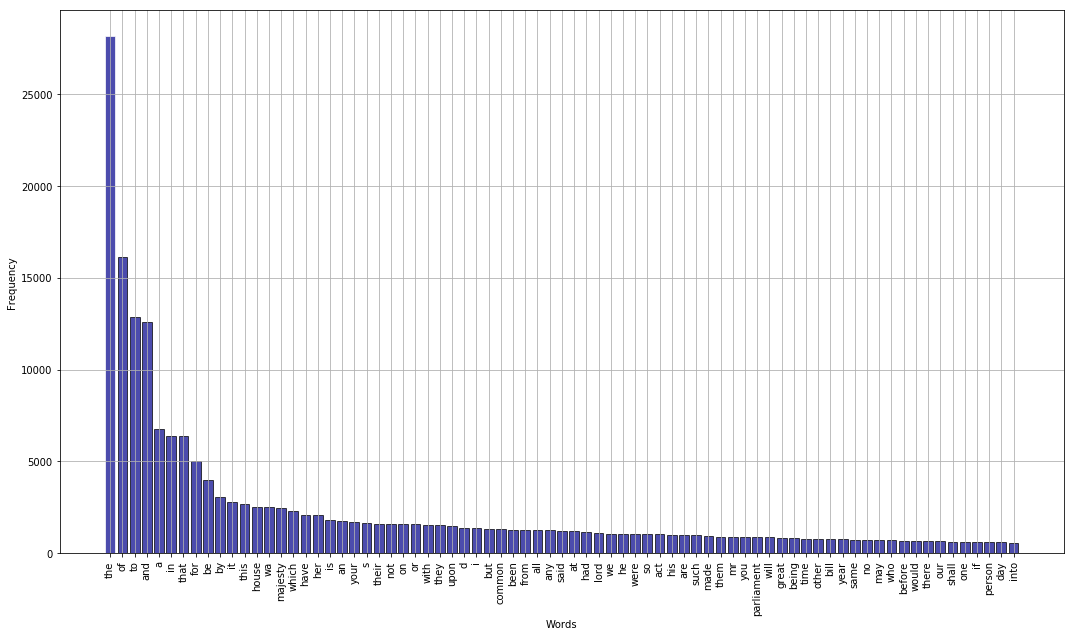

In [135]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plt.bar(freq_count.index, freq_count['frequency'].values, color = "darkblue", alpha = 0.7, edgecolor="white")
plt.xticks(freq_count.index, freq_count['word'].values, rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid()

plt.show()

## Fun stuff to do at home later.

In [136]:
cleaned_monarchs = []

for proceeding in df_monarch['proceedings']:

    #splits on white space and on punctuation + step0 clean up
    tokens = wordpunct_tokenize(step0(proceeding))
    
    #remove punctuation
    tokens = step1(tokens)
    
    #numbers
    tokens = step2(tokens)
    
    #lowercase
    tokens = step3(tokens)
    
    #remove stopwords
    tokens = step5(tokens)
    
    #remove rare words
    #tokens = step7(tokens)

    #stem
    tokens = [wl.lemmatize(token) for token in tokens] 
    
    cleaned_monarchs.append(tokens)

In [138]:
nltk_monarchs = []

for list_tokens in cleaned_monarchs:
    
    tokens = nltk.Text(list_tokens)
    nltk_monarchs.append(tokens)

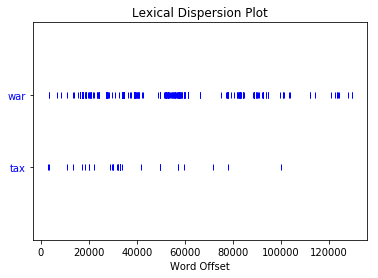

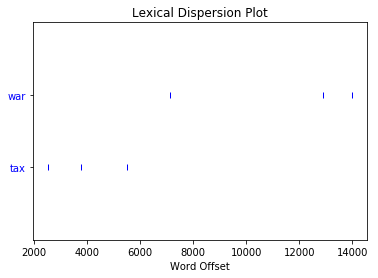

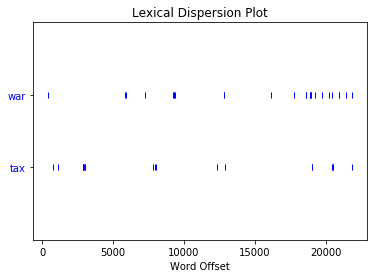

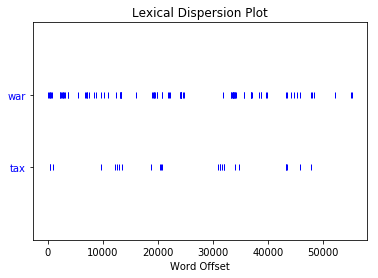

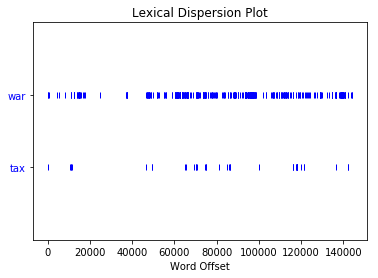

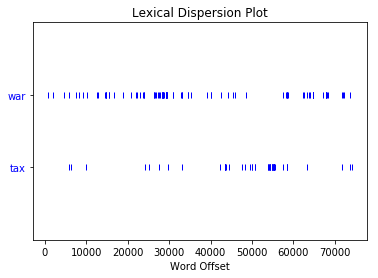

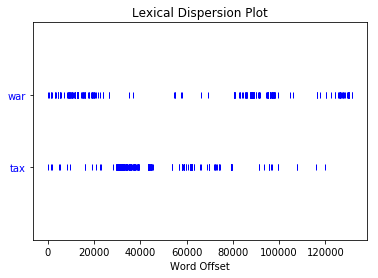

In [139]:
for text in nltk_monarchs:
    text.dispersion_plot(['war','tax'])

<font color=darkpurple>

# **In-class exercise / homework**

<font color=darkgreen>

## The Grimmer and Stewart (2013) Bag of Words recipe:

1. All words: unigrams or Named Entity bigrams (e.g. "White House")
2. Lemmatization ("family, families, families' and familial become famili")
3. ... discard "punctuation, capitalization, very common words ('stop' words) or functiona words), and very uncommon words (words that appear only once or twice in the corpus and thus are unlikely to be discriminating). We typically remove words which appear in less than 1% and more than 99% of documents in the corpus..."

In [76]:
def BagOWordsR():
    '''
    Takes in a corpus (vector of strings), maybe some arguments, and performs the following steps:
    
    1. Removes all numbers, punctuation, exit characters, html artifacts
    2. Splits on white space to create a list of words (i.e. tokens)
    3. Lowercases all tokens
    4. Stem all tokens using _____ stemmer
    5. Remove stop words *from across the corpus*.
    6. Remove rare words *from across the corpus*.
    
    ALSO: prints a percentage of # of tokens changed.
    
    List of strings --> List of strings; Int.
    
    '''
        
    